<a href="https://colab.research.google.com/github/Rohianon/ImageClassificationProjects/blob/main/MedMnistDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import random
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as om 
import torchvision as tv 
import torch.utils.data as dat 


if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    kwar = {'num_workers':8, 'pin_memory':True}
    cpu = torch.device('cpu')
else:
    print('Warning: CUDA not found, CPU only.')
    dev = torch.device('cpu')
    kwar = {}
    cpu = torch.device('cpu')

np.random.seed(603)


# Ensure code reproducibility


In [ ]:
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
cpu

device(type='cpu')

In [ ]:
!unzip resized.zip

Streaming output truncated to the last 5000 lines.
  inflating: resized/HeadCT/000002.jpeg  
  inflating: resized/HeadCT/000003.jpeg  
  inflating: resized/HeadCT/000010.jpeg  
  inflating: resized/HeadCT/000018.jpeg  
  inflating: resized/HeadCT/000027.jpeg  
  inflating: resized/HeadCT/000036.jpeg  
  inflating: resized/HeadCT/000038.jpeg  
  inflating: resized/HeadCT/000048.jpeg  
  inflating: resized/HeadCT/000054.jpeg  
  inflating: resized/HeadCT/000055.jpeg  
  inflating: resized/HeadCT/000058.jpeg  
  inflating: resized/HeadCT/000065.jpeg  
  inflating: resized/HeadCT/000074.jpeg  
  inflating: resized/HeadCT/000091.jpeg  
  inflating: resized/HeadCT/000100.jpeg  
  inflating: resized/HeadCT/000108.jpeg  
  inflating: resized/HeadCT/000113.jpeg  
  inflating: resized/HeadCT/000117.jpeg  
  inflating: resized/HeadCT/000127.jpeg  
  inflating: resized/HeadCT/000142.jpeg  
  inflating: resized/HeadCT/000159.jpeg  
  inflating: resized/HeadCT/000196.jpeg  
  inflating: resized/Head

In [ ]:
## Helper function to load up the dataset
def create_dataset(dir):
    # an unnested list of filenames
    imgFilesList = []

    # labels for each individual image in the list
    class_labels = []

    labels = os.listdir(dataDir)
    nClasses = len(labels)

    imgFiles = [[os.path.join(dataDir, labels[i], x)
     for x in tqdm(os.listdir(os.path.join(dataDir, labels[i])), desc=f"Loading Images from {labels[i]}")] 
     for i in range(nClasses)]

    # count of images in each category
    count_labels = [len(imgFiles[i]) for i in range(nClasses)]

    for i in range(nClasses):
        imgFilesList.extend(imgFiles[i])
        class_labels.extend([i]*count_labels[i])

    # total number of images
    total_imgs = len(class_labels)
    img_width, img_height = Image.open(imgFilesList[0]).size

    return imgFilesList, class_labels, labels, count_labels , total_imgs, img_width, img_height, nClasses   

In [ ]:
dataDir = 'resized'
imgFilesList, class_labels, labels,count_labels, total_imgs, img_width, img_height, nClasses = create_dataset(dataDir)

Loading Images from CXR: 100%|██████████| 10000/10000 [00:00<00:00, 444274.21it/s]


In [ ]:
total_imgs, nClasses, count_labels

(58954, 6, [10000, 8954, 10000, 10000, 10000, 10000])

In [ ]:
img_width

64

In [ ]:
def plot_random_image(imgFilesList, class_labels, labels):
    mp.subplots(3,3, figsize=(8,8))
    for i, k in enumerate(np.random.randint(len(class_labels), size=9)):
        im =Image.open(imgFilesList[k])

        # plot and label
        arr = np.array(im)
        mp.subplot(3,3, i+1)

        mp.xlabel(labels[class_labels[k]])
        mp.imshow(arr, cmap='gray', vmin=0, vmax=255)
    mp.tight_layout()
    return mp.show()



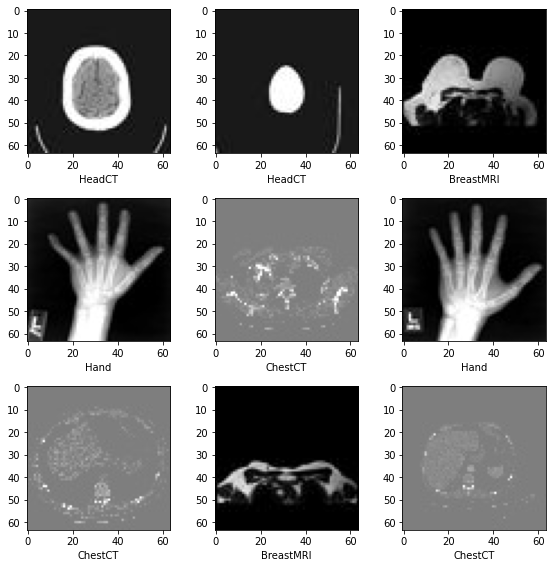

In [ ]:
plot_random_image(imgFilesList, class_labels, labels)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


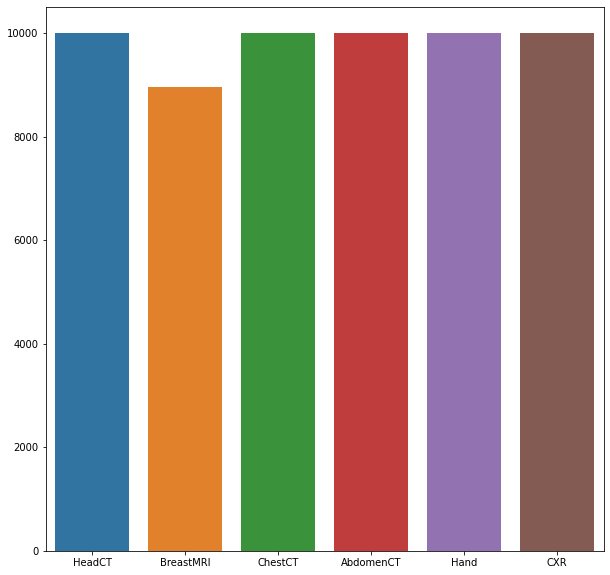

In [ ]:
mp.figure(figsize=(10,10))
sns.barplot(labels, count_labels);

In [ ]:
# Transforming and data partition.
# Min-max-scale 
toTensor = tv.transforms.ToTensor()

def scale_image(x):
    y = toTensor(x)
    if (y.min() < y.max()):
        y = (y-y.min())/(y.max()-y.min())
    z = y - y.mean()
    return z

def transform_(imgFilesList, class_labels):
    img_rescaled = torch.stack([scale_image(Image.open(x)) for x in imgFilesList])
    labels_rescaled = torch.tensor(class_labels)

    print(f'Min pixel value = {img_rescaled.min().item()}; Max = {img_rescaled.min().item()}; Mean = {img_rescaled.mean().item()}')

    return img_rescaled, labels_rescaled


In [ ]:
img_rescaled, labels_rescaled = transform_(imgFilesList, class_labels)

Min pixel value = -0.7857776284217834; Max = -0.7857776284217834; Mean = -2.766195716930042e-09


In [ ]:
# validation and test set

def num_split_points(total_imgs, fraction = 0.1):
    validList, testList, trainList = [],[],[]

    for data in range(total_imgs):
        # shuffle the dataset
        rn = np.random.random()
        if rn < fraction:
            validList.append(data)
        elif rn < 2*fraction:
            testList.append(data)
        else:
            trainList.append(data)
    return trainList, validList, testList
    

def count_data_items(trainList, validList, testList):
    # length of the split dataset
    ntrain, nvalid, ntest = len(trainList), len(validList), len(testList)
        # output the data shape
    print('Training images = ', ntrain, "Validation = ", nvalid, "Testing = ", ntest)
    return ntrain, nvalid, ntest

def split_data(img_rescaled, labels_rescaled,ntrain, nvalid, ntest):
    
    # id corresponding to the dataset
    trainid, testid, validid = torch.tensor(trainList),\
        torch.tensor(testList), torch.tensor(validList)

    # set of training and test set.
    xtrain = img_rescaled[trainid, :, :, :]
    xtest = img_rescaled[testid, :, :, :]
    xvalid = img_rescaled[validid, :, :, :]
    ytrain = labels_rescaled[trainid]
    ytest = labels_rescaled[testid]
    yvalid = labels_rescaled[validid]


    return xtrain, xtest, xvalid, ytrain, ytest, yvalid




In [ ]:
trainList, validList, testList = num_split_points(total_imgs)

ntrain, nvalid, ntest = count_data_items(trainList, validList, testList)

xtrain, xtest, xvalid, ytrain, ytest, yvalid = split_data(img_rescaled, labels_rescaled, ntrain, nvalid, ntest)

Training images =  47239 Validation =  5811 Testing =  5904


## Model Architecture

In [ ]:
class MedNet(nn.Module):
    def __init__(self,xDim,yDim,numC): # Pass image dimensions and number of labels when initializing a model   
        super(MedNet,self).__init__()  # Extends the basic nn.Module to the MedNet class
        # The parameters here define the architecture of the convolutional portion of the CNN. Each image pixel
        # has numConvs convolutions applied to it, and convSize is the number of surrounding pixels included
        # in each convolution. Lastly, the numNodesToFC formula calculates the final, remaining nodes at the last
        # level of convolutions so that this can be "flattened" and fed into the fully connected layers subsequently.
        # Each convolution makes the image a little smaller (convolutions do not, by default, "hang over" the edges
        # of the image), and this makes the effective image dimension decreases.
        
        numConvs1 = 5
        convSize1 = 7
        numConvs2 = 10
        convSize2 = 7
        numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))

        # nn.Conv2d(channels in, channels out, convolution height/width)
        # 1 channel -- grayscale -- feeds into the first convolution. The same number output from one layer must be
        # fed into the next. These variables actually store the weights between layers for the model.
        
        self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

        # These parameters define the number of output nodes of each fully connected layer.
        # Each layer must output the same number of nodes as the next layer begins with.
        # The final layer must have output nodes equal to the number of labels used.
        fcSize1 = 500
        fcSize2 = 100
        
        # nn.Linear(nodes in, nodes out)
        # Stores the weights between the fully connected layers
        
        self.ful1 = nn.Linear(numNodesToFC,fcSize1)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        self.ful3 = nn.Linear(fcSize2,numC)
        
    def forward(self,x):
        # This defines the steps used in the computation of output from input.
        # It makes uses of the weights defined in the __init__ method.
        # Each assignment of x here is the result of feeding the input up through one layer.
        # Here we use the activation function elu, which is a smoother version of the popular relu function.
        
        x = F.relu(self.cnv1(x)) # Feed through first convolutional layer, then apply activation
        x = F.relu(self.cnv2(x)) # Feed through second convolutional layer, apply activation
        x = x.view(-1,self.num_flat_features(x)) # Flatten convolutional layer into fully connected layer
        x = F.relu(self.ful1(x)) # Feed through first fully connected layer, apply activation
        x = F.relu(self.ful2(x)) # Feed through second FC layer, apply output
        x = self.ful3(x)        # Final FC layer to output. No activation, because it's used to calculate loss
        return x

    def num_flat_features(self, x):  # Count the individual nodes in a layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
model = MedNet(img_width, img_height, nClasses)
print(model.to(dev))

MedNet(
  (cnv1): Conv2d(1, 5, kernel_size=(7, 7), stride=(1, 1))
  (cnv2): Conv2d(5, 10, kernel_size=(7, 7), stride=(1, 1))
  (ful1): Linear(in_features=27040, out_features=500, bias=True)
  (ful2): Linear(in_features=500, out_features=100, bias=True)
  (ful3): Linear(in_features=100, out_features=6, bias=True)
)


In [ ]:
def train_model(model=model,xtrain=xtrain,ytrain=ytrain,xvalid=xvalid, yvalid=yvalid):
    # learning rate
    lr = 0.01
    # Maximum training epochs
    epochs = 20
    # Maximum allowed ratio of validation to training loss
    t2vRatio = 1.2
    # Consecutive epochs before halting if validation loss exceeds above limit
    t2vEpochs = 3

    # Batch size
    batch_size = 300
    train_model.batch_size = batch_size

    # Number of training batches per epoch
    train_batch = ntrain // batch_size
    print(train_batch,'training batches')
    train_model.train_batch = train_batch

    # Validation batches
    valid_batch = nvalid // batch_size
    print(valid_batch, 'validation batches')
    train_model.valid_batch = valid_batch

    # test batch 
    test_batch = -(-ntest//batch_size)
    print(test_batch,'test batches')
    train_model.test_batch = test_batch

    # incase of any class imbalance
    CEweights = torch.zeros(nClasses)

    for i in ytrain.tolist():
        # cater for any class imbalances
        CEweights[i].add_(1)

    # Weights should be inversely related to count
    CEweights = 1. / CEweights.clamp_(min=1)
    # The weights should average to 1
    CEweights = (CEweights * nClasses/ CEweights.sum()).to(dev)

    # initialize an optimizer
    opti = om.SGD(model.parameters(), lr = lr)


    epochs_used = []
    training_accuracy = []
    train_loss = []
    valid_loss = []
    valid_accuracy = []
    test_loss = []
    test_accuracy = []

    for i in range(epochs):
        # Set model for training
        model.train()
        epochLoss = 0
        # shuffle data for random batches
        permute = torch.randperm(ntrain)

        xtrain = xtrain[permute, :, :, :]
        ytrain = ytrain[permute]

        # iterate over batches
        for j in range(train_batch):
            opti.zero_grad()

            xbatch = xtrain[j*batch_size: (j+1) * batch_size, :, :, :].to(dev)
            ybatch = ytrain[j*batch_size: (j+1) * batch_size].to(dev)
            # evaluate predictions
            y = model(xbatch)
            # compute the loss
            loss = F.cross_entropy(y, ybatch, weight=CEweights)
            #add loss
            epochLoss += loss.item()
            # back propagate
            loss.backward()
            # update model weights using optimizer
            opti.step()
            # epochLoss.append(loss.item())

        validLoss = 0
        permute = torch.randperm(nvalid)
        # go through similar proces without backpropagation and optimization
        xvalid = xvalid[permute, :, :, :]
        yvalid = yvalid[permute]

        # set model to evaluation mode
        with torch.no_grad(): # shut down gradient descent temporarily
            for j in range(valid_batch):
                opti.zero_grad()
                xbatch = xvalid[j*batch_size:(j+1)*batch_size, :, :, :].to(dev)
                ybatch = yvalid[j*batch_size:(j+1)*batch_size].to(dev)
                y = model(xbatch)
                validLoss += F.cross_entropy(y, ybatch, weight=CEweights).item()
        # average loss over batches and print it out
        epochLoss /= train_batch
        validLoss /= valid_batch

        train_loss.append(epochLoss)
        valid_loss.append(validLoss)
        epochs_used.append(i)

        print(f'Epoch = {i:-3}; Training Loss = {epochLoss:.4f}; Validation Loss = {validLoss:.4f}')

        # Test if validatio loss exceed halting threshold
        epoch_used = []
        if validLoss > t2vRatio * epochLoss:
            t2vEpochs -= 1
            if t2vEpochs < 1:
                print('Validation loss to high; halting to prevent overfitting')
                break

    return train_loss, valid_loss, epochs_used




In [ ]:
%%time
train_loss, valid_loss, epochs_used = train_model()

157 training batches
19 validation batches
20 test batches
Epoch =   0; Training Loss = 0.9891; Validation Loss = 0.2270
Epoch =   1; Training Loss = 0.1703; Validation Loss = 0.1232
Epoch =   2; Training Loss = 0.1760; Validation Loss = 0.1329
Epoch =   3; Training Loss = 0.0915; Validation Loss = 0.0674
Epoch =   4; Training Loss = 0.0621; Validation Loss = 0.0467
Epoch =   5; Training Loss = 0.0489; Validation Loss = 0.0524
Epoch =   6; Training Loss = 0.0411; Validation Loss = 0.0322
Epoch =   7; Training Loss = 0.0340; Validation Loss = 0.0272
Epoch =   8; Training Loss = 0.0296; Validation Loss = 0.0255
Epoch =   9; Training Loss = 0.0261; Validation Loss = 0.0293
Epoch =  10; Training Loss = 0.0222; Validation Loss = 0.0196
Epoch =  11; Training Loss = 0.0205; Validation Loss = 0.0195
Epoch =  12; Training Loss = 0.0173; Validation Loss = 0.0159
Epoch =  13; Training Loss = 0.0158; Validation Loss = 0.0184
Epoch =  14; Training Loss = 0.0141; Validation Loss = 0.0227
Epoch =  15

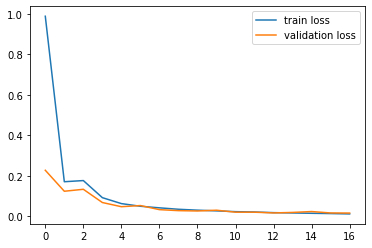

In [ ]:
def my_plot(epochs, loss,label):
    mp.plot(epochs, loss, label=label)
    mp.legend()
    # mp.plot(epochs, loss)


my_plot(epochs_used, train_loss,'train loss')
my_plot(epochs_used, valid_loss, 'validation loss')

## Model Testing

In [ ]:
def confusion_matrix(model,test_batch,batch_size,xtest=xtest, ytest=ytest, nClasses=nClasses, labels=labels):

    matrix = np.zeros((nClasses, nClasses), dtype=int)
    model.eval()
    with torch.no_grad():
        # shuffle the test data
        permute = torch.randperm(len(ytest))

        xtest = xtest[permute, :, :, :]
        ytest = ytest[permute]

        for j in range(test_batch):
            xbatch = xtest[j*batch_size:(j+1)*batch_size, :, :,:].to(dev)
            ybatch = ytest[j*batch_size:(j+1)*batch_size].to(dev)

            y = model(xbatch)

            pred = y.max(1, keepdim=True)[1]

            for j in torch.cat((ybatch.view_as(pred), pred), dim=1).tolist():
                # actual and predicted
                matrix[j[0],j[1]] += 1
    correct = sum([matrix[i,i] for i in range(nClasses)])

    print("Correct predictions: ", correct, "of", ntest)
    print(":-----Consufion Matrix----:")
    print(matrix)
    print(labels)
    x = sns.heatmap(matrix, fmt='.0f', annot=True)
    x.set_title(f'{model}')
    return mp.show(x)

        

Correct predictions:  5873 of 5904
:-----Consufion Matrix----:
[[1037    0    0    0    2    0]
 [   0  922    3    0    0    0]
 [   0    1  966    2    0    0]
 [   0    0   12  954    0    0]
 [   3    0    0    0  986    0]
 [   2    0    0    0    6 1008]]
['HeadCT', 'BreastMRI', 'ChestCT', 'AbdomenCT', 'Hand', 'CXR']


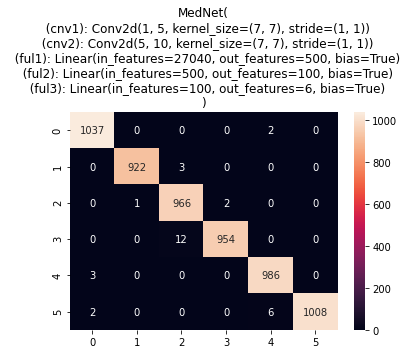

In [ ]:
test_batch = train_model.test_batch
batch_size = train_model.batch_size
confusion_matrix(model,test_batch, batch_size)

# Elu Functions

In [ ]:
class MedNet(nn.Module):
    def __init__(self,xDim,yDim,numC): # Pass image dimensions and number of labels when initializing a model   
        super(MedNet,self).__init__()  # Extends the basic nn.Module to the MedNet class
        # The parameters here define the architecture of the convolutional portion of the CNN. Each image pixel
        # has numConvs convolutions applied to it, and convSize is the number of surrounding pixels included
        # in each convolution. Lastly, the numNodesToFC formula calculates the final, remaining nodes at the last
        # level of convolutions so that this can be "flattened" and fed into the fully connected layers subsequently.
        # Each convolution makes the image a little smaller (convolutions do not, by default, "hang over" the edges
        # of the image), and this makes the effective image dimension decreases.
        
        numConvs1 = 5
        convSize1 = 7
        numConvs2 = 10
        convSize2 = 7
        numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))

        # nn.Conv2d(channels in, channels out, convolution height/width)
        # 1 channel -- grayscale -- feeds into the first convolution. The same number output from one layer must be
        # fed into the next. These variables actually store the weights between layers for the model.
        
        self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

        # These parameters define the number of output nodes of each fully connected layer.
        # Each layer must output the same number of nodes as the next layer begins with.
        # The final layer must have output nodes equal to the number of labels used.
        fcSize1 = 500
        fcSize2 = 100
        
        # nn.Linear(nodes in, nodes out)
        # Stores the weights between the fully connected layers
        
        self.ful1 = nn.Linear(numNodesToFC,fcSize1)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        self.ful3 = nn.Linear(fcSize2,numC)
        
    def forward(self,x):
        # This defines the steps used in the computation of output from input.
        # It makes uses of the weights defined in the __init__ method.
        # Each assignment of x here is the result of feeding the input up through one layer.
        # Here we use the activation function elu, which is a smoother version of the popular relu function.
        
        x = F.elu(self.cnv1(x)) # Feed through first convolutional layer, then apply activation
        x = F.elu(self.cnv2(x)) # Feed through second convolutional layer, apply activation
        x = x.view(-1,self.num_flat_features(x)) # Flatten convolutional layer into fully connected layer
        x = F.elu(self.ful1(x)) # Feed through first fully connected layer, apply activation
        x = F.elu(self.ful2(x)) # Feed through second FC layer, apply output
        x = self.ful3(x)        # Final FC layer to output. No activation, because it's used to calculate loss
        return x

    def num_flat_features(self, x):  # Count the individual nodes in a layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
model1 = MedNet(img_width, img_height, nClasses)
model1.to(dev)

MedNet(
  (cnv1): Conv2d(1, 5, kernel_size=(7, 7), stride=(1, 1))
  (cnv2): Conv2d(5, 10, kernel_size=(7, 7), stride=(1, 1))
  (ful1): Linear(in_features=27040, out_features=500, bias=True)
  (ful2): Linear(in_features=500, out_features=100, bias=True)
  (ful3): Linear(in_features=100, out_features=6, bias=True)
)

In [ ]:
%%time
train_loss, valid_loss, epochs_used = train_model(model=model1)

157 training batches
19 validation batches
20 test batches
Epoch =   0; Training Loss = 0.7071; Validation Loss = 0.2068
Epoch =   1; Training Loss = 0.1603; Validation Loss = 0.1157
Epoch =   2; Training Loss = 0.0954; Validation Loss = 0.0728
Epoch =   3; Training Loss = 0.0633; Validation Loss = 0.0511
Epoch =   4; Training Loss = 0.0463; Validation Loss = 0.0378
Epoch =   5; Training Loss = 0.0359; Validation Loss = 0.0288
Epoch =   6; Training Loss = 0.0296; Validation Loss = 0.0240
Epoch =   7; Training Loss = 0.0247; Validation Loss = 0.0210
Epoch =   8; Training Loss = 0.0211; Validation Loss = 0.0175
Epoch =   9; Training Loss = 0.0186; Validation Loss = 0.0178
Epoch =  10; Training Loss = 0.0167; Validation Loss = 0.0158
Epoch =  11; Training Loss = 0.0144; Validation Loss = 0.0150
Epoch =  12; Training Loss = 0.0133; Validation Loss = 0.0129
Epoch =  13; Training Loss = 0.0118; Validation Loss = 0.0124
Epoch =  14; Training Loss = 0.0107; Validation Loss = 0.0117
Epoch =  15

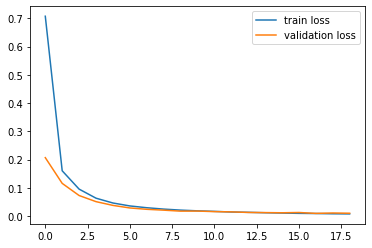

In [ ]:
my_plot(epochs_used, train_loss, 'train loss')
my_plot(epochs_used, valid_loss, 'validation loss')

Correct predictions:  5884 of 5904
:-----Consufion Matrix----:
[[1037    0    0    0    2    0]
 [   0  924    1    0    0    0]
 [   0    1  963    5    0    0]
 [   0    0    4  962    0    0]
 [   3    0    0    0  986    0]
 [   1    1    0    0    2 1012]]
['HeadCT', 'BreastMRI', 'ChestCT', 'AbdomenCT', 'Hand', 'CXR']


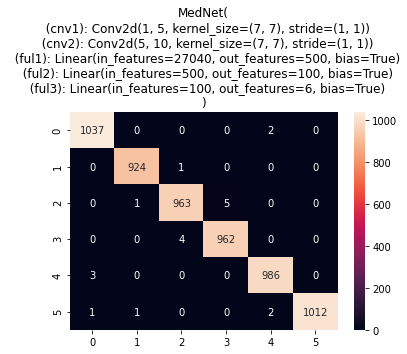

In [ ]:
test_batch = train_model.test_batch
batch_size = train_model.batch_size
confusion_matrix(model1,test_batch, batch_size)

# Tanh

In [ ]:
class MedNet(nn.Module):
    def __init__(self,xDim,yDim,numC): # Pass image dimensions and number of labels when initializing a model   
        super(MedNet,self).__init__()  # Extends the basic nn.Module to the MedNet class
        # The parameters here define the architecture of the convolutional portion of the CNN. Each image pixel
        # has numConvs convolutions applied to it, and convSize is the number of surrounding pixels included
        # in each convolution. Lastly, the numNodesToFC formula calculates the final, remaining nodes at the last
        # level of convolutions so that this can be "flattened" and fed into the fully connected layers subsequently.
        # Each convolution makes the image a little smaller (convolutions do not, by default, "hang over" the edges
        # of the image), and this makes the effective image dimension decreases.
        
        numConvs1 = 5
        convSize1 = 7
        numConvs2 = 10
        convSize2 = 7
        numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))

        # nn.Conv2d(channels in, channels out, convolution height/width)
        # 1 channel -- grayscale -- feeds into the first convolution. The same number output from one layer must be
        # fed into the next. These variables actually store the weights between layers for the model.
        
        self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

        # These parameters define the number of output nodes of each fully connected layer.
        # Each layer must output the same number of nodes as the next layer begins with.
        # The final layer must have output nodes equal to the number of labels used.
        fcSize1 = 500
        fcSize2 = 100
        
        # nn.Linear(nodes in, nodes out)
        # Stores the weights between the fully connected layers
        
        self.ful1 = nn.Linear(numNodesToFC,fcSize1)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        self.ful3 = nn.Linear(fcSize2,numC)
        
    def forward(self,x):
        # This defines the steps used in the computation of output from input.
        # It makes uses of the weights defined in the __init__ method.
        # Each assignment of x here is the result of feeding the input up through one layer.
        # Here we use the activation function elu, which is a smoother version of the popular relu function.
        
        x = torch.tanh(self.cnv1(x)) # Feed through first convolutional layer, then apply activation
        x = torch.tanh(self.cnv2(x)) # Feed through second convolutional layer, apply activation
        x = x.view(-1,self.num_flat_features(x)) # Flatten convolutional layer into fully connected layer
        x = torch.tanh(self.ful1(x)) # Feed through first fully connected layer, apply activation
        x = torch.tanh(self.ful2(x)) # Feed through second FC layer, apply output
        x = self.ful3(x)        # Final FC layer to output. No activation, because it's used to calculate loss
        return x

    def num_flat_features(self, x):  # Count the individual nodes in a layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
model2 = MedNet(img_width, img_height, nClasses)
model2.to(dev)

MedNet(
  (cnv1): Conv2d(1, 5, kernel_size=(7, 7), stride=(1, 1))
  (cnv2): Conv2d(5, 10, kernel_size=(7, 7), stride=(1, 1))
  (ful1): Linear(in_features=27040, out_features=500, bias=True)
  (ful2): Linear(in_features=500, out_features=100, bias=True)
  (ful3): Linear(in_features=100, out_features=6, bias=True)
)

In [ ]:
%%time
train_loss, valid_loss, epochs_used = train_model(model=model2)

157 training batches
19 validation batches
20 test batches
Epoch =   0; Training Loss = 0.7803; Validation Loss = 0.3194
Epoch =   1; Training Loss = 0.2562; Validation Loss = 0.2044
Epoch =   2; Training Loss = 0.1860; Validation Loss = 0.1619
Epoch =   3; Training Loss = 0.1525; Validation Loss = 0.1378
Epoch =   4; Training Loss = 0.1302; Validation Loss = 0.1172
Epoch =   5; Training Loss = 0.1136; Validation Loss = 0.1021
Epoch =   6; Training Loss = 0.0993; Validation Loss = 0.0903
Epoch =   7; Training Loss = 0.0878; Validation Loss = 0.0804
Epoch =   8; Training Loss = 0.0776; Validation Loss = 0.0712
Epoch =   9; Training Loss = 0.0684; Validation Loss = 0.0632
Epoch =  10; Training Loss = 0.0616; Validation Loss = 0.0569
Epoch =  11; Training Loss = 0.0555; Validation Loss = 0.0528
Epoch =  12; Training Loss = 0.0506; Validation Loss = 0.0480
Epoch =  13; Training Loss = 0.0462; Validation Loss = 0.0462
Epoch =  14; Training Loss = 0.0424; Validation Loss = 0.0425
Epoch =  15

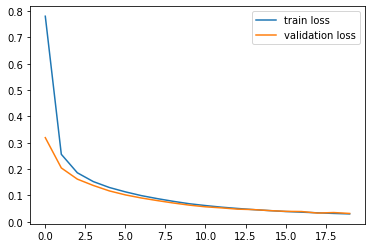

In [ ]:
my_plot(epochs_used, train_loss, 'train loss')
my_plot(epochs_used, valid_loss, 'validation loss')

20
300
Correct predictions:  5862 of 5904
:-----Consufion Matrix----:
[[1037    0    0    1    1    0]
 [   0  922    3    0    0    0]
 [   0    1  965    3    0    0]
 [   0    0   13  953    0    0]
 [   4    1    2    3  978    1]
 [   0    2    3    0    4 1007]]
['HeadCT', 'BreastMRI', 'ChestCT', 'AbdomenCT', 'Hand', 'CXR']


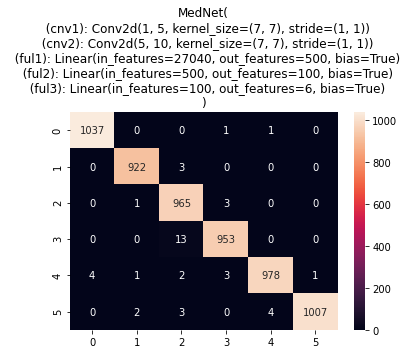

In [ ]:
test_batch = train_model.test_batch
print(test_batch)
batch_size = train_model.batch_size
print(batch_size)
confusion_matrix(model2,test_batch, batch_size)

# Leaky Relu

In [ ]:
# class MedNet(nn.Module):
#     def __init__(self,xDim,yDim,numC): # Pass image dimensions and number of labels when initializing a model   
#         super(MedNet,self).__init__()  # Extends the basic nn.Module to the MedNet class
#         # The parameters here define the architecture of the convolutional portion of the CNN. Each image pixel
#         # has numConvs convolutions applied to it, and convSize is the number of surrounding pixels included
#         # in each convolution. Lastly, the numNodesToFC formula calculates the final, remaining nodes at the last
#         # level of convolutions so that this can be "flattened" and fed into the fully connected layers subsequently.
#         # Each convolution makes the image a little smaller (convolutions do not, by default, "hang over" the edges
#         # of the image), and this makes the effective image dimension decreases.
        
#         numConvs1 = 5
#         convSize1 = 7
#         numConvs2 = 10
#         convSize2 = 7
#         numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))

#         # nn.Conv2d(channels in, channels out, convolution height/width)
#         # 1 channel -- grayscale -- feeds into the first convolution. The same number output from one layer must be
#         # fed into the next. These variables actually store the weights between layers for the model.
        
#         self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
#         self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

#         # These parameters define the number of output nodes of each fully connected layer.
#         # Each layer must output the same number of nodes as the next layer begins with.
#         # The final layer must have output nodes equal to the number of labels used.
#         fcSize1 = 500
#         fcSize2 = 100
        
#         # nn.Linear(nodes in, nodes out)
#         # Stores the weights between the fully connected layers
        
#         self.ful1 = nn.Linear(numNodesToFC,fcSize1)
#         self.ful2 = nn.Linear(fcSize1, fcSize2)
#         self.ful3 = nn.Linear(fcSize2,numC)
        
#     def forward(self,x):
#         # This defines the steps used in the computation of output from input.
#         # It makes uses of the weights defined in the __init__ method.
#         # Each assignment of x here is the result of feeding the input up through one layer.
#         # Here we use the activation function elu, which is a smoother version of the popular relu function.
        
#         x = nn.LeakyReLU(self.cnv1(x)) # Feed through first convolutional layer, then apply activation
#         x = nn.LeakyReLU(self.cnv2(x)) # Feed through second convolutional layer, apply activation
#         x = x.view(-1,self.num_flat_features(x)) # Flatten convolutional layer into fully connected layer
#         x = nn.LeakyReLU(self.ful1(x)) # Feed through first fully connected layer, apply activation
#         x = nn.LeakyReLU(self.ful2(x)) # Feed through second FC layer, apply output
#         x = self.ful3(x)        # Final FC layer to output. No activation, because it's used to calculate loss
#         return x

#     def num_flat_features(self, x):  # Count the individual nodes in a layer
#         size = x.size()[1:]
#         num_features = 1
#         for s in size:
#             num_features *= s
#         return num_features

In [ ]:
# model3 = MedNet(img_width, img_height, nClasses)
# model3.to(dev)

MedNet(
  (cnv1): Conv2d(1, 5, kernel_size=(7, 7), stride=(1, 1))
  (cnv2): Conv2d(5, 10, kernel_size=(7, 7), stride=(1, 1))
  (ful1): Linear(in_features=27040, out_features=500, bias=True)
  (ful2): Linear(in_features=500, out_features=100, bias=True)
  (ful3): Linear(in_features=100, out_features=6, bias=True)
)

In [ ]:
# train_loss, valid_loss, epochs_used = train_model(model=model3)

In [ ]:
# my_plot(epochs_used, train_loss)
# # my_plot(epochs_used, valid_loss)

In [ ]:
# test_batch = train_model.test_batch
# batch_size = train_model.batch_size
# confusion_matrix(model3,test_batch, batch_size)

# SReLU

In [ ]:
# !pip install echoAI

In [ ]:
# from  echoAI.Activation import t_ops as E

# class MedNet(nn.Module):
#     def __init__(self,xDim,yDim,numC): # Pass image dimensions and number of labels when initializing a model   
#         super(MedNet,self).__init__()  # Extends the basic nn.Module to the MedNet class
#         # The parameters here define the architecture of the convolutional portion of the CNN. Each image pixel
#         # has numConvs convolutions applied to it, and convSize is the number of surrounding pixels included
#         # in each convolution. Lastly, the numNodesToFC formula calculates the final, remaining nodes at the last
#         # level of convolutions so that this can be "flattened" and fed into the fully connected layers subsequently.
#         # Each convolution makes the image a little smaller (convolutions do not, by default, "hang over" the edges
#         # of the image), and this makes the effective image dimension decreases.
        
#         numConvs1 = 5
#         convSize1 = 7
#         numConvs2 = 10
#         convSize2 = 7
#         numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))

#         # nn.Conv2d(channels in, channels out, convolution height/width)
#         # 1 channel -- grayscale -- feeds into the first convolution. The same number output from one layer must be
#         # fed into the next. These variables actually store the weights between layers for the model.
        
#         self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
#         self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

#         # These parameters define the number of output nodes of each fully connected layer.
#         # Each layer must output the same number of nodes as the next layer begins with.
#         # The final layer must have output nodes equal to the number of labels used.
#         fcSize1 = 500
#         fcSize2 = 100
        
#         # nn.Linear(nodes in, nodes out)
#         # Stores the weights between the fully connected layers
        
#         self.ful1 = nn.Linear(numNodesToFC,fcSize1)
#         self.ful2 = nn.Linear(fcSize1, fcSize2)
#         self.ful3 = nn.Linear(fcSize2,numC)
        
#     def forward(self,x):
#         # This defines the steps used in the computation of output from input.
#         # It makes uses of the weights defined in the __init__ method.
#         # Each assignment of x here is the result of feeding the input up through one layer.
#         # Here we use the activation function elu, which is a smoother version of the popular relu function.
        
#         x = E.SReLU(self.cnv1(x)) # Feed through first convolutional layer, then apply activation
#         x = E.SReLU(self.cnv2(x)) # Feed through second convolutional layer, apply activation
#         x = x.view(-1,self.num_flat_features(x)) # Flatten convolutional layer into fully connected layer
#         x = E.SReLU(self.ful1(x)) # Feed through first fully connected layer, apply activation
#         x = E.SReLU(self.ful2(x)) # Feed through second FC layer, apply output
#         x = self.ful3(x)        # Final FC layer to output. No activation, because it's used to calculate loss
#         return x

#     def num_flat_features(self, x):  # Count the individual nodes in a layer
#         size = x.size()[1:]
#         num_features = 1
#         for s in size:
#             num_features *= s
#         return num_features

In [ ]:
# model4 = MedNet(img_width, img_height, nClasses)
# model4.to(dev)

In [ ]:
# train_loss, valid_loss, epochs_used = train_model(model=model4)

In [ ]:
# my_plot(epochs_used, train_loss, 'train loss')
# my_plot(epochs_used, valid_loss, 'validation loss')

In [ ]:
# test_batch = train_model.test_batch
# batch_size = train_model.batch_size
# confusion_matrix(model4,test_batch, batch_size)

# TeLU

In [ ]:
class MedNet(nn.Module):
    def __init__(self,xDim,yDim,numC): # Pass image dimensions and number of labels when initializing a model   
        super(MedNet,self).__init__()  # Extends the basic nn.Module to the MedNet class
        # The parameters here define the architecture of the convolutional portion of the CNN. Each image pixel
        # has numConvs convolutions applied to it, and convSize is the number of surrounding pixels included
        # in each convolution. Lastly, the numNodesToFC formula calculates the final, remaining nodes at the last
        # level of convolutions so that this can be "flattened" and fed into the fully connected layers subsequently.
        # Each convolution makes the image a little smaller (convolutions do not, by default, "hang over" the edges
        # of the image), and this makes the effective image dimension decreases.
        
        numConvs1 = 5
        convSize1 = 7
        numConvs2 = 10
        convSize2 = 7
        numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))

        # nn.Conv2d(channels in, channels out, convolution height/width)
        # 1 channel -- grayscale -- feeds into the first convolution. The same number output from one layer must be
        # fed into the next. These variables actually store the weights between layers for the model.
        
        self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

        # These parameters define the number of output nodes of each fully connected layer.
        # Each layer must output the same number of nodes as the next layer begins with.
        # The final layer must have output nodes equal to the number of labels used.
        fcSize1 = 500
        fcSize2 = 100
        
        # nn.Linear(nodes in, nodes out)
        # Stores the weights between the fully connected layers
        
        self.ful1 = nn.Linear(numNodesToFC,fcSize1)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        self.ful3 = nn.Linear(fcSize2,numC)
        
    def forward(self,x):
        # This defines the steps used in the computation of output from input.
        # It makes uses of the weights defined in the __init__ method.
        # Each assignment of x here is the result of feeding the input up through one layer.
        # Here we use the activation function elu, which is a smoother version of the popular relu function.
        
        x = torch.tanh(F.elu(self.cnv1(x))) # Feed through first convolutional layer, then apply activation
        x = torch.tanh(F.elu(self.cnv2(x))) # Feed through second convolutional layer, apply activation
        x = x.view(-1,self.num_flat_features(x)) # Flatten convolutional layer into fully connected layer
        x = torch.tanh(F.elu(self.ful1(x))) # Feed through first fully connected layer, apply activation
        x = torch.tanh(F.elu(self.ful2(x))) # Feed through second FC layer, apply output
        x = self.ful3(x)        # Final FC layer to output. No activation, because it's used to calculate loss
        return x

    def num_flat_features(self, x):  # Count the individual nodes in a layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
model5 = MedNet(img_width, img_height, nClasses)
model5.to(dev)

MedNet(
  (cnv1): Conv2d(1, 5, kernel_size=(7, 7), stride=(1, 1))
  (cnv2): Conv2d(5, 10, kernel_size=(7, 7), stride=(1, 1))
  (ful1): Linear(in_features=27040, out_features=500, bias=True)
  (ful2): Linear(in_features=500, out_features=100, bias=True)
  (ful3): Linear(in_features=100, out_features=6, bias=True)
)

In [ ]:
%%time
train_loss, valid_loss, epochs_used = train_model(model=model5)

157 training batches
19 validation batches
20 test batches
Epoch =   0; Training Loss = 0.3043; Validation Loss = 0.2378
Epoch =   1; Training Loss = 0.2019; Validation Loss = 0.1679
Epoch =   2; Training Loss = 0.1488; Validation Loss = 0.1264
Epoch =   3; Training Loss = 0.1174; Validation Loss = 0.1019
Epoch =   4; Training Loss = 0.0971; Validation Loss = 0.0859
Epoch =   5; Training Loss = 0.0824; Validation Loss = 0.0748
Epoch =   6; Training Loss = 0.0717; Validation Loss = 0.0635
Epoch =   7; Training Loss = 0.0631; Validation Loss = 0.0559
Epoch =   8; Training Loss = 0.0562; Validation Loss = 0.0510
Epoch =   9; Training Loss = 0.0506; Validation Loss = 0.0468
Epoch =  10; Training Loss = 0.0462; Validation Loss = 0.0417
Epoch =  11; Training Loss = 0.0425; Validation Loss = 0.0392
Epoch =  12; Training Loss = 0.0389; Validation Loss = 0.0404
Epoch =  13; Training Loss = 0.0363; Validation Loss = 0.0328
Epoch =  14; Training Loss = 0.0337; Validation Loss = 0.0321
Epoch =  15

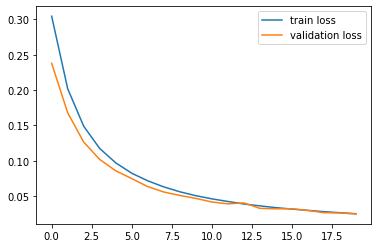

In [ ]:
my_plot(epochs_used, train_loss, 'train loss')
my_plot(epochs_used, valid_loss, 'validation loss')

Correct predictions:  5864 of 5904
:-----Consufion Matrix----:
[[1038    0    0    0    1    0]
 [   0  924    1    0    0    0]
 [   0    2  964    3    0    0]
 [   1    0   10  955    0    0]
 [   4    2    2    3  977    1]
 [   1    1    3    1    4 1006]]
['HeadCT', 'BreastMRI', 'ChestCT', 'AbdomenCT', 'Hand', 'CXR']


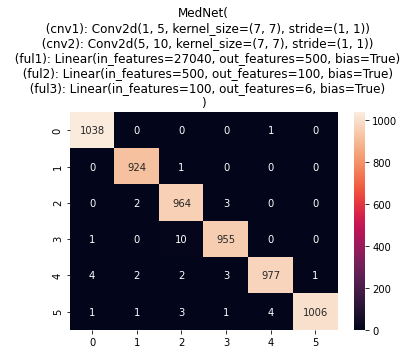

In [ ]:
test_batch = train_model.test_batch
batch_size = train_model.batch_size
confusion_matrix(model5,test_batch, batch_size)

In [ ]:
def scaleBack(x):               # Pass a tensor, return a numpy array from 0 to 1
    if(x.min() < x.max()):      # Assuming the image isn't empty, rescale so its values run from 0 to 1
        x = (x - x.min())/(x.max() - x.min())
    return x[0].to(cpu).numpy() # Remove channel (grayscale anyway)

In [ ]:
model5.eval()
mp.subplots(3,3,figsize=(8,8))
imagesLeft = 9
permute = torch.randperm(ntest)        # Shuffle test data
xtest = xtest[permute,:,:,:]
ytest = ytest[permute]
for j in range(test_batch):              # Iterate over test batches
    batX = xtest[j*batch_size:(j+1)*batch_size,:,:,:].to(dev)
    batY = ytest[j*batch_size:(j+1)*batch_size].to(dev)
    yOut = model5(batX)                 # Pass test batch through model
    pred = yOut.max(1)[1].tolist()     # Generate predictions by finding the max Y values
    for i, y in enumerate(batY.tolist()):
        if imagesLeft and y != pred[i]:         # Compare the actual y value to the prediction
            imagesLeft -= 1
            mp.subplot(3,3,9-imagesLeft)
            mp.xlabel(labels[pred[i]])      # Label image with what the model thinks it is
            mp.imshow(scaleBack(batX[i]),cmap='gray',vmin=0,vmax=1)
mp.tight_layout()
mp.show()